<a href="https://colab.research.google.com/github/gabiacuna/KL2021/blob/main/Analisis%20de%20Imagenes%20con%20DL/004-Deteccion-de-Objetos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detección de Objectos

En este tutorial veremos como se puede utilizar Pytorch para entrenar un modelo de detección
de objetos.

Usaremos la base de datos [*Penn-Fudan Database for Pedestrian Detection and Segmentation*](https://www.cis.upenn.edu/~jshi/ped_html/)
y la entrenaremos utilizando un modelo de [Mask R-CNN](https://arxiv.org/abs/1703.06870). Este modelu incluye un total de
170 imágenes con 345 instancias de peatones, y lo usaremos para ver como podemos extraer "features" para entrenar un modelo

In [2]:
# Instalamos los paquetes necesarios
!pip install -r https://raw.githubusercontent.com/vcalderon2009/2021_06_Deep_Learning_tutorial/master/pkg_requirements.txt -q

     |████████████████████████████████| 3.6MB 36.5MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 8.2MB 46.3MB/s 
     |████████████████████████████████| 143kB 36.8MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 7.7MB 44.6MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 71kB 9.5MB/s 
     |████████████████████████████████| 430kB 45.8MB/s 
     |████████████████████████████████| 399kB 44.1MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 727kB 41.8MB/s 
     |████████████████████████████████| 747kB 47.8MB/s 
     |████████████████████████████████| 122kB 49.6MB/s 
     |████████████████████████████████| 81kB 11.5MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
ERROR: google-colab 1.0.0 has requirement tornado~=5.1.0; pyt

In [3]:
# Importing modules
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import shutil

## Dataset

Primero bajamos la base de datos en la carpeta actual:

In [4]:
# download the Penn-Fudan dataset
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
# extract it in the current folder
!unzip PennFudanPed.zip

--2021-07-01 23:52:29--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M   181MB/s    in 0.3s    

2021-07-01 23:52:29 (181 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

--2021-07-01 23:52:29--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-07-01 23:52:29--
Total wall clock time: 0.4s
Downloaded: 1 files, 51M in 0.3s (181 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennF

Ahora podemos ver la estructura de esta nueva carpeta:

```
PennFudanPed/
  PedMasks/
    FudanPed00001_mask.png
    FudanPed00002_mask.png
    FudanPed00003_mask.png
    FudanPed00004_mask.png
    ...
  PNGImages/
    FudanPed00001.png
    FudanPed00002.png
    FudanPed00003.png
    FudanPed00004.png
```

Cada una de estas imágenes tiene asociado las máscaras que enseñan en donde es que hay personas.

Por ejemplo, podemos ver una de estas imágenes:

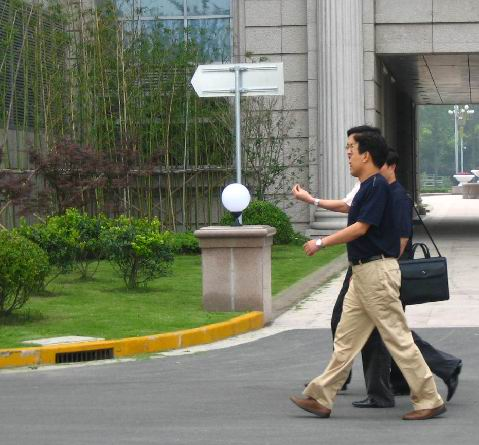

In [5]:
from PIL import Image

# Número de imagen
image_number = "00003"

Image.open(f'PennFudanPed/PNGImages/FudanPed{image_number}.png')

Y también podemos ver la **máscara** asociada a esta imagen:

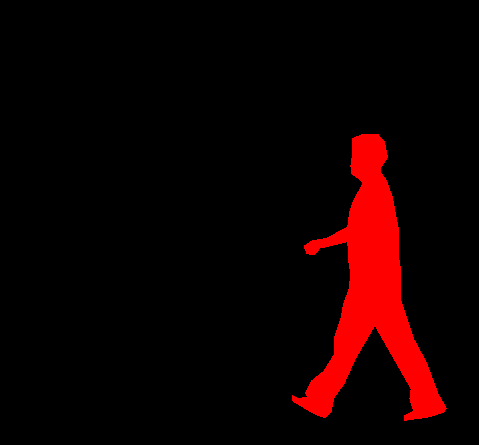

In [6]:
mask = Image.open(f'PennFudanPed/PedMasks/FudanPed{image_number}_mask.png')
# cada instancia de máscara tiene un color diferente, de cero a N, donde
# N es el número de instancias. Para facilitar la visualización,
# agreguemos paleta de colores a la máscara.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

Esto significal que cada imagen tiene una máscara de segmentación asociada, en donde el color corresponde a las
diferentes instancias.

## Dataloader

La siguiente parte es el **Dataset**, en donde se define como leer y ejecutar la data:

In [7]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # Lee todas las imágenes y las ordena para ver que estén todas alineadas
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # Leyendo las imágenes y máscaras
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # NOTE: tenga en cuenta que no hemos convertido la máscara a RGB,
        # porque cada color corresponde a una instancia diferente
        # siendo 0 el fondo
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # las instancias están codificadas como colores diferentes
        obj_ids = np.unique(mask)
        # la primera identificación es el fondo, así que elimínela
        obj_ids = obj_ids[1:]

        # dividir la máscara codificada por colores en un conjunto
        # de máscaras binarias
        masks = mask == obj_ids[:, None, None]

        # obtener las coordenadas del cuadro delimitador para cada máscara
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Solamente hay una clase para acá
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # supongamos que no todas las instancias son multitud
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

Ahora que ya hemos definido el objecto del `Dataset`, podemos ver como se estructura los objetos:

In [8]:
dataset = PennFudanDataset('PennFudanPed/')
dataset[100]

(<PIL.Image.Image image mode=RGB size=492x391 at 0x7FB0CA21AF50>,
 {'area': tensor([23220., 33748., 29348.]),
  'boxes': tensor([[125.,  92., 211., 362.],
          [203.,  80., 321., 366.],
          [346.,  88., 462., 341.]]),
  'image_id': tensor([100]),
  'iscrowd': tensor([0, 0, 0]),
  'labels': tensor([1, 1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  

Este objecto devuelve lo siguite:
- La imágen en formato de `PIL.image`.
- Un diccionario con el metadata de `boxes`, `labels`, y `masks`. Toda esta información se puede utilizar para entrenar un modelo.

### Modelaje

En este tutorial, usaremos [Mask R-CNN](https://arxiv.org/abs/1703.06870), el cual está basado en la red neural [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN
es un modelo que predice tanto cuadros delimitadores como puntuaciones de clase para objetos potenciales en la imagen.

![Faster R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image03.png)

Mask R-CNN agrega una rama adicional a Faster R-CNN, que también predice máscaras de segmentación para cada instancia.

![Mask R-CNN](https://raw.githubusercontent.com/pytorch/vision/temp-tutorial/tutorials/tv_image04.png)

##### Entrenando el modelo

Para este tutorial usaremos un modelo que ya ha sido entrenado previamente, y utilizaremos las pesas
de este modelo para aplicarlo a nuestra base de datos:

In [9]:
# Importamos los módulos necesarios, como los modelos y demás
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [10]:
def get_instance_segmentation_model(num_classes):
    # En este caso, estamos cargando ya un modelo entrenado de RESNET sobre la
    # base de COCO.
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) #Pedimos un modelo reentrenado

    # Obtenemos el número de características de entrada para el clasificador
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Reemplazamos la cabeza previamente entrenada por una nueva.
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Ahora podemos obtener el número de características de entrada para el clasificador de máscara
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

Ahora necesitamos copiar unos archivos de `Pytorch` para usarlos acá:

In [11]:
!git clone -b v0.3.0 --single-branch https://github.com/pytorch/vision.git  #Bajamos esta vercion (v0.3.0) pk funca con este ejemplo

Cloning into 'vision'...
remote: Enumerating objects: 2810, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 2810 (delta 2), reused 0 (delta 0), pack-reused 2805
Receiving objects: 100% (2810/2810), 2.43 MiB | 25.62 MiB/s, done.
Resolving deltas: 100% (1838/1838), done.


In [12]:
# Now we can copy files from the following location
for file_ii in ["utils.py", "transforms.py", "coco_eval.py", "engine.py", "coco_utils.py"]:
    shutil.copy(f"./vision/references/detection/{file_ii}", ".")    #Copiamos los arch de la carpeta al directorio actual

Y ahora podemos escribir las funciones para transformar las imágenes:

In [13]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [14]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Ahora creamos el dataset total:

In [15]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(      #entrenamiento
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(     #Test
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
len(data_loader_test)

50

In [17]:
len(data_loader)

60

Modificamos los datos de entrenamiento, pero no de validacion. Pk nos interesa enternar al modelo con datos modificados, no validarlo con estos.

batch_size es sobre cuantos datos a la vez se modifica el modelo. entrenamos el modelo poco a poco. 
num_works es para decirle cuantos cpus se pueden usar, se usan para procesamiento paralelo, lo que reduce bastante el tiempo de ejecución. 

In [19]:
torch.cuda.is_available()

True

Y empezamos el entrenamiento del modelo:

In [20]:
#decidimos que modelo utilizar, en devise podemos elegir si usar cpu o gpu

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

# our dataset has two classes only - background and person
num_classes = 2     #Solo encuentra el fondo y una persona

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


In [21]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

Esto usa el engine.py

Iteramos sobre el diferente número de épocas:

In [22]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step() #Modificamos la velocidad de aprendizage, nmas arriba fue definido por cuanto
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: [0]  [ 0/60]  eta: 0:01:16  lr: 0.000090  loss: 2.7900 (2.7900)  loss_classifier: 0.7402 (0.7402)  loss_box_reg: 0.3405 (0.3405)  loss_mask: 1.6637 (1.6637)  loss_objectness: 0.0430 (0.0430)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 1.2816  data: 0.2661  max mem: 2162
Epoch: [0]  [10/60]  eta: 0:00:32  lr: 0.000936  loss: 1.3925 (1.7266)  loss_classifier: 0.5136 (0.4822)  loss_box_reg: 0.2960 (0.2981)  loss_mask: 0.7157 (0.9198)  loss_objectness: 0.0169 (0.0217)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 0.6562  data: 0.0322  max mem: 3317
Epoch: [0]  [20/60]  eta: 0:00:24  lr: 0.001783  loss: 1.0071 (1.2308)  loss_classifier: 0.2243 (0.3355)  loss_box_reg: 0.2910 (0.2865)  loss_mask: 0.3238 (0.5871)  loss_objectness: 0.0109 (0.0171)  loss_rpn_box_reg: 0.0042 (0.0045)  time: 0.5703  data: 0.0086  max mem: 3317
Epoch: [0]  [30/60]  eta: 0:00:18  lr: 0.002629  loss: 0.5534 (1.0160)  loss_classifier: 0.0991 (0.2556)  loss_box_reg: 0.2664 (0.2870)  loss_mask: 0.1831 (0.4537)  loss_ob

[IOU](https://medium.com/analytics-vidhya/iou-intersection-over-union-705a39e7acef) : interseccion sobre la union. Es como el porcentaje de aciertos

#### Evaluciación del modelo

Ahora podemos ver que tan bien aprendió el modelo:

Las fotos que usaremos ahora, el modelo nunca las ha visto

In [26]:
dataset_test[0]

(tensor([[[0.4902, 0.4784, 0.4745,  ..., 0.0627, 0.0627, 0.0627],
          [0.4784, 0.4667, 0.4706,  ..., 0.0667, 0.0667, 0.0667],
          [0.4706, 0.4667, 0.4745,  ..., 0.0784, 0.0784, 0.0784],
          ...,
          [0.8431, 0.8118, 0.8000,  ..., 0.8235, 0.8392, 0.8431],
          [0.8588, 0.8314, 0.7843,  ..., 0.8275, 0.8118, 0.7882],
          [0.8627, 0.8627, 0.8000,  ..., 0.8392, 0.7961, 0.7490]],
 
         [[0.3059, 0.2941, 0.2902,  ..., 0.0706, 0.0706, 0.0706],
          [0.2941, 0.2824, 0.2863,  ..., 0.0745, 0.0745, 0.0745],
          [0.2863, 0.2824, 0.2902,  ..., 0.0863, 0.0863, 0.0863],
          ...,
          [0.8039, 0.7725, 0.7608,  ..., 0.7843, 0.8000, 0.8039],
          [0.8196, 0.7922, 0.7451,  ..., 0.7882, 0.7725, 0.7490],
          [0.8235, 0.8235, 0.7608,  ..., 0.8000, 0.7569, 0.7098]],
 
         [[0.2431, 0.2314, 0.2275,  ..., 0.0667, 0.0667, 0.0667],
          [0.2314, 0.2196, 0.2235,  ..., 0.0706, 0.0706, 0.0706],
          [0.2235, 0.2196, 0.2275,  ...,

In [44]:
# pick one image from the test set
img, _ = dataset_test[3]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])    #Input del modelo

In [27]:
prediction

[{'boxes': tensor([[ 64.2639,  37.2576, 199.3462, 327.9248],
          [276.6483,  23.5383, 290.7400,  73.3125]], device='cuda:0'),
  'labels': tensor([1, 1], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0'),
  'scores': tensor([0.9986, 0.4858], device='cuda:0')}]

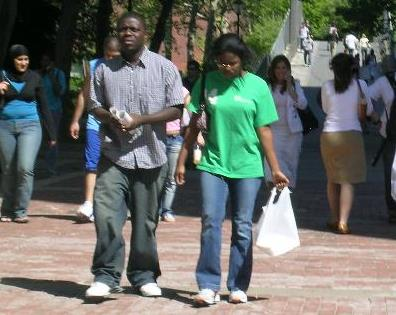

In [45]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

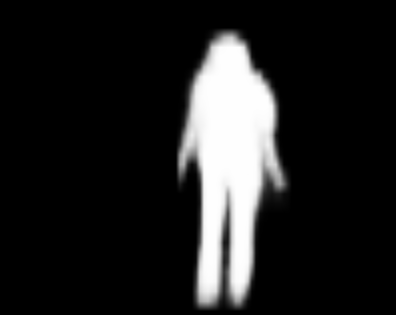

In [46]:
# Y esta es la máscara
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy()) #El .cpu es pk la imagen y el modelo estan en el cpu!!!

ya que no hay profundidad no diferencia ente personas que estan 'adelante' o 'atras'